# Dataset: 48_Schabath_2016

In [2]:
import pandas as pd

file_path= "data/48_Schabath_2016.xlsx"
df = pd.read_excel(file_path)

df.head()

,Pat_ID,Pat_Gender,Pat_Age,Pat_Race,Pat_Smoking_Status,Pat_Packs_Per_Year,Pat_Histology,Pat_Adjuvant_Chemo,Pat_Neoadjuvant_Chemo,Pat_Radiation,...,Pat_Substage,Pat_Grade,Pat_EGFR_mutation,Pat_KRAS_mutation,Pat_ALK_translocation,Pat_TP53_mutation,Pat_STK11_mutation,Pat_Tumor_Site,Pat_ICDO_code,Pat_SNOMED_code
0,GSE72094_001,F,88.0,NaN,NaN,NaN,11010000,NaN,NaN,NaN,...,NaN,NaN,1,0,NaN,1,0,NaN,8140/3,35917007
1,GSE72094_002,F,70.0,1.0,1.0,NaN,11010000,NaN,NaN,NaN,...,NaN,NaN,0,0,NaN,0,0,NaN,8140/3,35917007
2,GSE72094_003,F,59.0,1.0,1.0,NaN,11010000,NaN,NaN,NaN,...,B,NaN,0,0,NaN,0,0,NaN,8140/3,35917007
3,GSE72094_004,M,57.0,1.0,NaN,NaN,11010000,NaN,NaN,NaN,...,B,NaN,0,0,NaN,1,0,NaN,8140/3,35917007
4,GSE72094_005,F,72.0,1.0,4.0,0.0,11010000,NaN,NaN,NaN,...,B,NaN,0,0,NaN,0,0,NaN,8140/3,35917007


## Genes

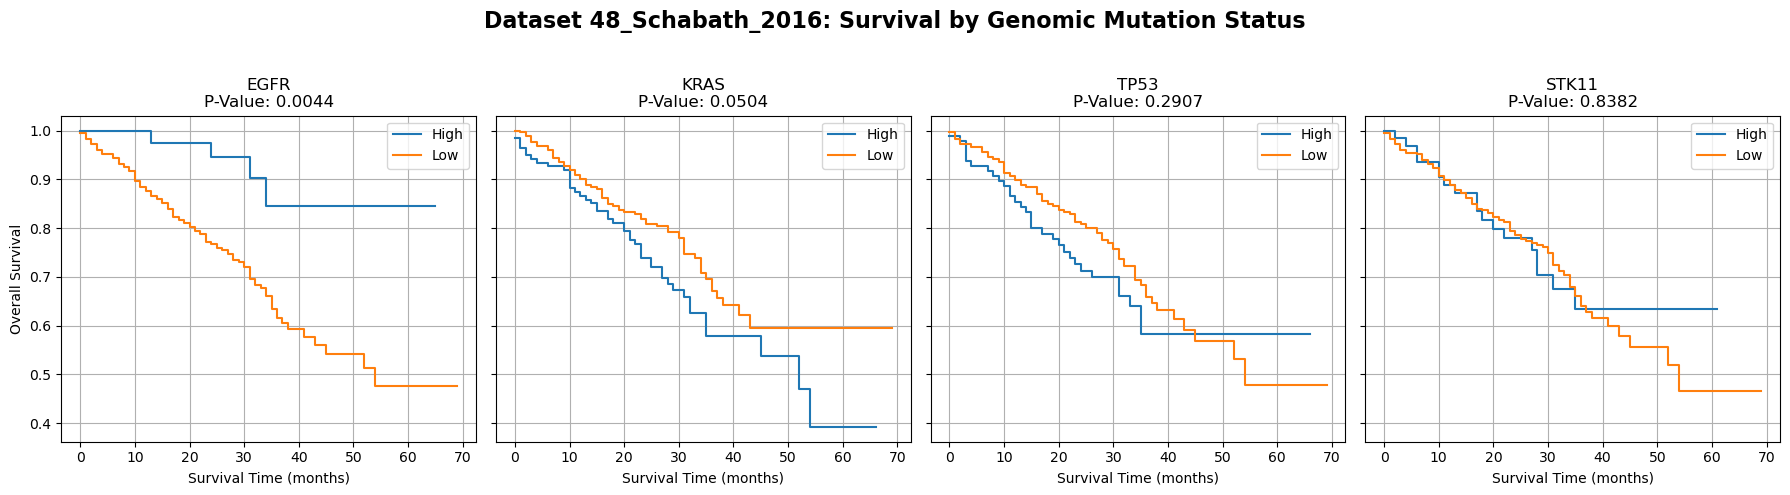

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test


duration_col = "Pat_Overall_Survival_Months"
event_col = "Pat_Died"

# Genes to analyze
genes = ["Pat_EGFR_mutation", "Pat_KRAS_mutation", "Pat_TP53_mutation", "Pat_STK11_mutation"]

# Plot
fig, axes = plt.subplots(1, len(genes), figsize=(18, 5), sharey=True)
fig.suptitle("Dataset 48_Schabath_2016: Survival by Genomic Mutation Status", fontsize=16, weight='bold')

for i, gene in enumerate(genes):
    ax = axes[i]
    
    # Drop NaNs for current gene
    sub_df = df[[duration_col, event_col, gene]].dropna()
    
    # Create groups based on median value
    threshold = sub_df[gene].median()
    sub_df['Group'] = sub_df[gene].apply(lambda x: 'High' if x > threshold else 'Low')
    
    # Kaplan-Meier curves
    kmf = KaplanMeierFitter()
    for label, grouped in sub_df.groupby('Group'):
        kmf.fit(grouped[duration_col], grouped[event_col], label=label)
        kmf.plot_survival_function(ax=ax, ci_show=False)
    
    # Log-rank test
    high = sub_df[sub_df['Group'] == 'High']
    low = sub_df[sub_df['Group'] == 'Low']
    result = logrank_test(high[duration_col], low[duration_col], event_observed_A=high[event_col], event_observed_B=low[event_col])
    
    # Plot customization
    ax.set_title(f"{gene.replace('Pat_', '').replace('_mutation', '')}\nP-Value: {result.p_value:.4f}")
    ax.set_xlabel("Survival Time (months)")
    if i == 0:
        ax.set_ylabel("Overall Survival")
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Cancer Stage

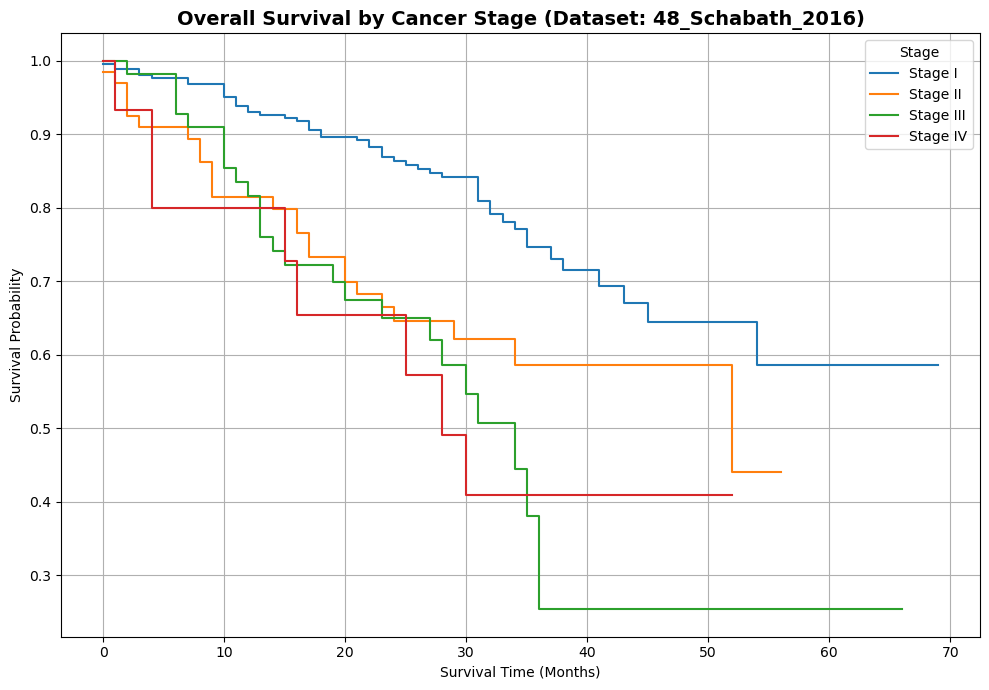

In [10]:
valid_survival_df = df[['Pat_Overall_Survival_Months', 'Pat_Died', 'Pat_Stage']].dropna()

# Get unique stages
unique_stages = valid_survival_df['Pat_Stage'].dropna().unique()

# Initialize plot
plt.figure(figsize=(10, 7))
kmf = KaplanMeierFitter()

# Plot curves for each stage
for stage in sorted(unique_stages):
    stage_data = valid_survival_df[valid_survival_df['Pat_Stage'] == stage]
    kmf.fit(stage_data['Pat_Overall_Survival_Months'], event_observed=stage_data['Pat_Died'], label=f"Stage {stage}")
    kmf.plot_survival_function(ci_show=False)

# Customize
plt.title("Overall Survival by Cancer Stage (Dataset: 48_Schabath_2016)", fontsize=14, weight='bold')
plt.xlabel("Survival Time (Months)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend(title="Stage")
plt.tight_layout()
plt.show()

## Cox Model

In [8]:
from lifelines import CoxPHFitter


columns = ['Pat_Overall_Survival_Months', 'Pat_Died', 'Pat_Age', 'Pat_Race', 'Pat_Gender', 'Pat_Stage', 'Pat_EGFR_mutation', 'Pat_KRAS_mutation', 'Pat_TP53_mutation', 'Pat_STK11_mutation']
df_subset = df[columns].dropna()

# One-hot encode
df_encoded = pd.get_dummies(df_subset, columns=['Pat_Gender', 'Pat_Stage'], drop_first=True)

df_encoded.rename(columns={
    'Pat_Overall_Survival_Months': 'OS_Months',
    'Pat_Died': 'Event',
    'Pat_Age': 'Age'
}, inplace=True)

# Fit Cox model
cph = CoxPHFitter()
cph.fit(df_encoded, duration_col='OS_Months', event_col='Event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 390 total observations, 280 right-censored observations>
             duration col = 'OS_Months'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 390
number of events observed = 110
   partial log-likelihood = -574.82
         time fit was run = 2025-05-21 16:42:42 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
Age                  0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
Pat_Race            -0.01       0.99       0.31            -0.62             0.60                 0.54                 1.81
Pat_EGFR_mutation   -1.17       0.31       0.52            -2.19            -0.15                 0.11                 0.86
Pat_KRAS_mutation    0.28       1.32       0.20            -0.12             0.67                 0.89                 1.96
Pat_TP53_mutation    0.01       1.01       0.23            -0.43             0.46                 0.65                 1.58
Pat_STK11_mutation  -0.32       0.72       0.27            -0.85             0.20                 0.43                 1.23
Pat_Gender_M         0.51       1.67       0.20             0.12             0.90                 1.13                 2.46
Pat_Stage_II         0.76       2.13       0.25             0.28             1.24                 1.32                 3.46
Pat_Stage_III        1.18       3.25       0.25             0.69             1.67                 1.99                 5.31
Pat_Stage_IV         1.26       3.51       0.39             0.49             2.02                 1.64                 7.54

                     cmp to     z      p   -log2(p)
covariate                                          
Age                    0.00  0.37   0.71       0.49
Pat_Race               0.00 -0.05   0.96       0.05
Pat_EGFR_mutation      0.00 -2.25   0.02       5.37
Pat_KRAS_mutation      0.00  1.39   0.17       2.59
Pat_TP53_mutation      0.00  0.06   0.95       0.08
Pat_STK11_mutation     0.00 -1.20   0.23       2.13
Pat_Gender_M           0.00  2.57   0.01       6.60
Pat_Stage_II           0.00  3.09 <0.005       8.95
Pat_Stage_III          0.00  4.71 <0.005      18.60
Pat_Stage_IV           0.00  3.22 <0.005       9.63
---
Concordance = 0.69
Partial AIC = 1169.63
log-likelihood ratio test = 46.89 on 10 df
-log2(p) of ll-ratio test = 19.95

<Axes: xlabel='log(HR) (95% CI)'>

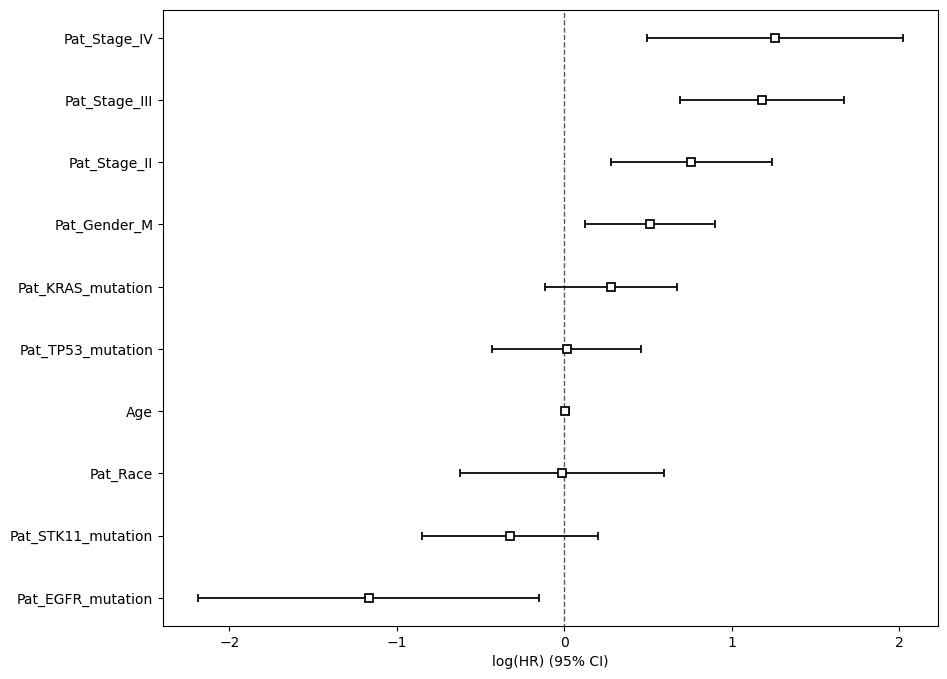

In [9]:
plt.figure(figsize=(10, 8)) 
cph.plot()

# Dataset: By Dr. Mathur

In [11]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Load the data
df = pd.read_excel('data/Summary of response for Dr. Mathur.xlsx')

In [12]:
df = df.rename(columns={"Response in Patients, CR: Complete Response, PD: Progressive Disease, PR: Partial Response, SD: Stable Disease": "Response in Patients", "Died Yes 1 No 2": "Dead", "Se (F: Female, M; Male)": "Gender", "Race/Ethnicity: AA-African American, W:White": "Ethnicity", "IO-treated Yes 1, No 2": "IO_treated"})


In [13]:
# Define the mapping
label_mapping = {1: 1, 2:0}


df['Dead'] = df['Dead'].map(label_mapping)

In [14]:
df["PD-L1 %"] = df["PD-L1 %"].astype(str)

# Remove '%' and convert to numeric
df["PD-L1 %"] = df["PD-L1 %"].str.rstrip("%").astype(float)

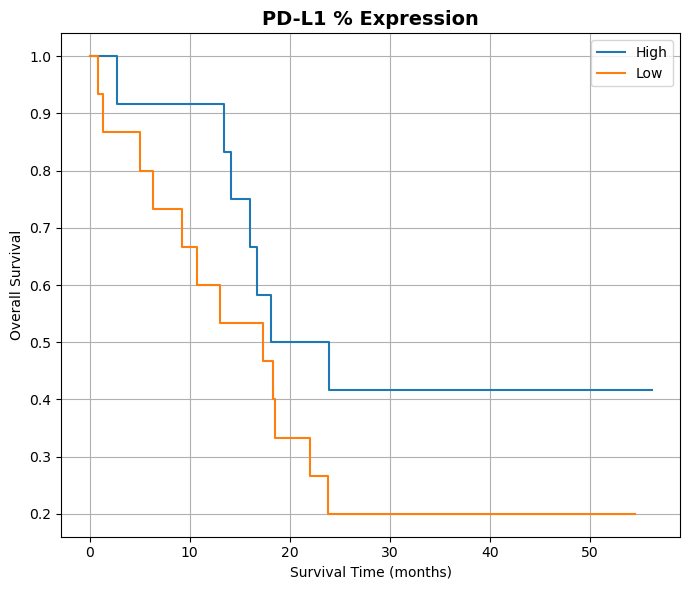

In [16]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt


threshold = df["PD-L1 %"].median()
df['PDL1_Group'] = df["PD-L1 %"].apply(lambda x: 'High' if x > threshold else 'Low')

# Fit Kaplan-Meier curves
kmf = KaplanMeierFitter()
plt.figure(figsize=(7, 6))

for label, grouped_df in df.groupby('PDL1_Group'):
    kmf.fit(grouped_df['Overall Survival (months)'], event_observed=grouped_df['Dead'], label=label)
    kmf.plot_survival_function(ci_show=False)

plt.title("PD-L1 % Expression", fontsize=14, weight='bold')
plt.xlabel("Survival Time (months)")
plt.ylabel("Overall Survival")
plt.grid(True)
plt.tight_layout()
plt.legend(title=None)
plt.show()